## Lectura 10-3: Validación cruzada

## Técnicas de estimación del rendimiento
* Evaluar siempre los modelos _como si predijeran datos futuros_
* No tenemos acceso a los datos futuros, así que fingimos que algunos datos están ocultos
* Manera más sencilla: la _holdout_ (simple división entrenamiento-prueba)
    - Dividir aleatoriamente los datos (y las etiquetas correspondientes) en un conjunto de entrenamiento y otro de prueba (por ejemplo, 75%-25%).
    - Entrene (ajuste) un modelo con los datos de entrenamiento, evalue con los datos de prueba

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit, train_test_split,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
from matplotlib.patches import Patch
np.random.seed(1338)
cmap_data = plt.cm.brg
cmap_group = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
rng = np.random.RandomState(42)
group_prior = rng.dirichlet([2]*10)
rng.multinomial(100, group_prior)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))

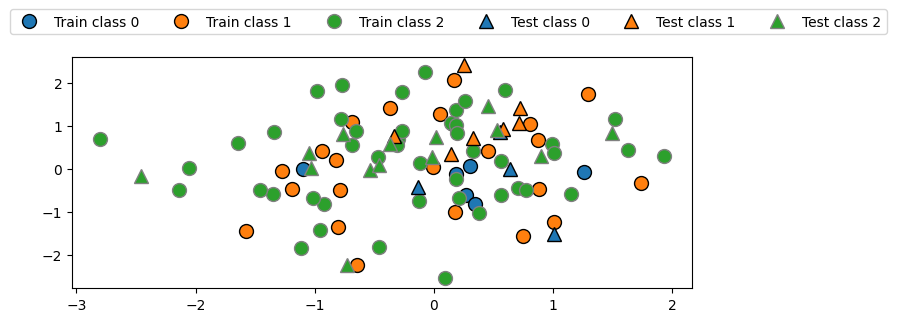

In [6]:
import mglearn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
fig, ax = plt.subplots(figsize=(8, 3))
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                         markers='o', ax=ax)
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                         markers='^', ax=ax)
ax.legend(["Train class 0", "Train class 1", "Train class 2", "Test class 0",
                "Test class 1", "Test class 2"], ncol=6,  loc=(-0.1, 1.1));

### Validación cruzada K-fold
- Cada división aleatoria puede dar lugar a modelos (y puntuaciones) muy diferentes
    - por ejemplo, todos los ejemplos fáciles (o difíciles) podrían acabar en el conjunto de prueba
- Divida los datos en _k_ partes del mismo tamaño, denominadas _pliegues_.
    - Cree _k_ divisiones, utilizando cada vez un pliegue diferente como conjunto de prueba.
- Calcule _k_ puntuaciones de evaluación, agréguelas después (por ejemplo, tome la media).
- Examine la varianza de las puntuaciones para ver lo _sensibles_ (inestables) que son los modelos.
- Un _k_ grande da mejores estimaciones (más datos de entrenamiento), pero es caro computacionalmente 

In [9]:
def plot_cv_indices(cv, X, y, group, ax, lw=2, show_groups=False, s=700, legend=True):
    """Create a sample plot for indices of a cross-validation object."""
    n_splits = cv.get_n_splits(X, y, group)

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter([n_splits - ii - 1] * len(indices), range(len(indices)),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2, s=s)

    # Plot the data classes and groups at the end
    ax.scatter([-1] * len(X), range(len(X)), 
               c=y, marker='_', lw=lw, cmap=cmap_data, s=s)
    yticklabels = ['class'] + list(range(1, n_splits + 1))
    
    if show_groups:
        ax.scatter([-2] * len(X), range(len(X)), 
                   c=group, marker='_', lw=lw, cmap=cmap_group, s=s)
        yticklabels.insert(0, 'group')

    # Formatting
    ax.set(xticks=np.arange(-1 - show_groups, n_splits), xticklabels=yticklabels,
            ylabel='Sample index', xlabel="CV iteration",
            xlim=[-1.5 - show_groups, n_splits+.2], ylim=[-6, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    if legend:
        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
                  ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks(())
    return ax

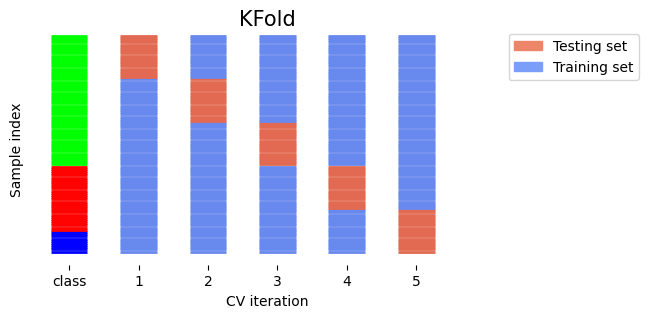

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))
cv = KFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700);

¿Puede explicar este resultado?

``` python
kfold = KFold(n_splits=3)
cross_val_score(logistic_regression, iris.data, iris.target, cv=kfold)
```

In [16]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()
kfold = KFold(n_splits=3)
print("Cross-validation scores KFold(n_splits=3):\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores KFold(n_splits=3):
[0. 0. 0.]


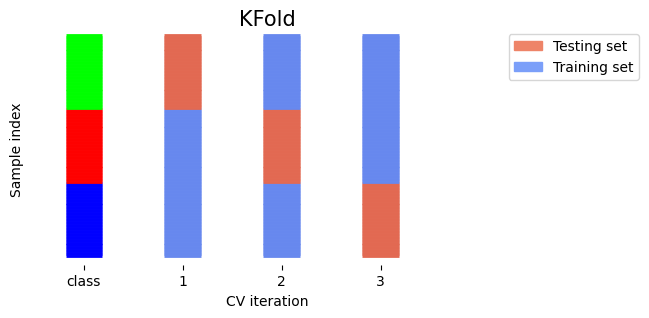

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(kfold, iris.data, iris.target, iris.target, ax, s=700)
ax.set_ylim((-6, 150));

#### Validación cruzada K-Fold estratificada

- Si los datos están desequilibrados, algunas clases tienen pocas muestras
- Es probable que algunas clases no estén presentes en el conjunto de prueba 
- Estratificación: Las _proporciones_ entre clases se conservan en cada pliegue
    - Ordenar los ejemplos por clase
    - Separe las muestras de cada clase en _k_ conjuntos (estratos)
    - Combinar los estratos correspondientes en pliegues

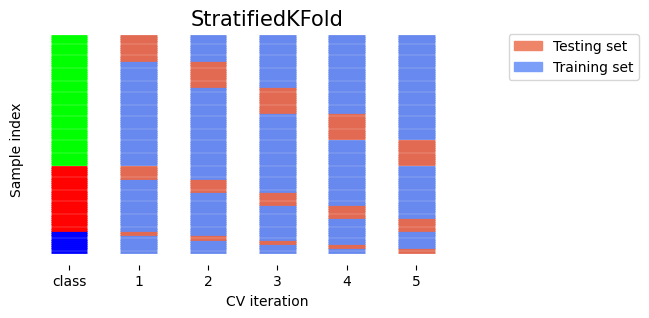

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
cv = StratifiedKFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700)
ax.set_ylim((-6, 100));

#### Validación cruzada Leave-One-Out

- Validación cruzada de _k_ pliegues con _k_ igual al número de muestras
- Completamente insesgada (en términos de división de datos), pero costosa desde el punto de vista computacional
- En realidad generaliza _menos_ bien hacia datos no vistos
    - Los conjuntos de entrenamiento están correlacionados (se solapan mucho)
    - Se ajusta en exceso a los datos utilizados para la evaluación (completa).
    - Una muestra diferente de los datos puede dar resultados distintos.
- Sólo se recomienda para conjuntos de datos pequeños

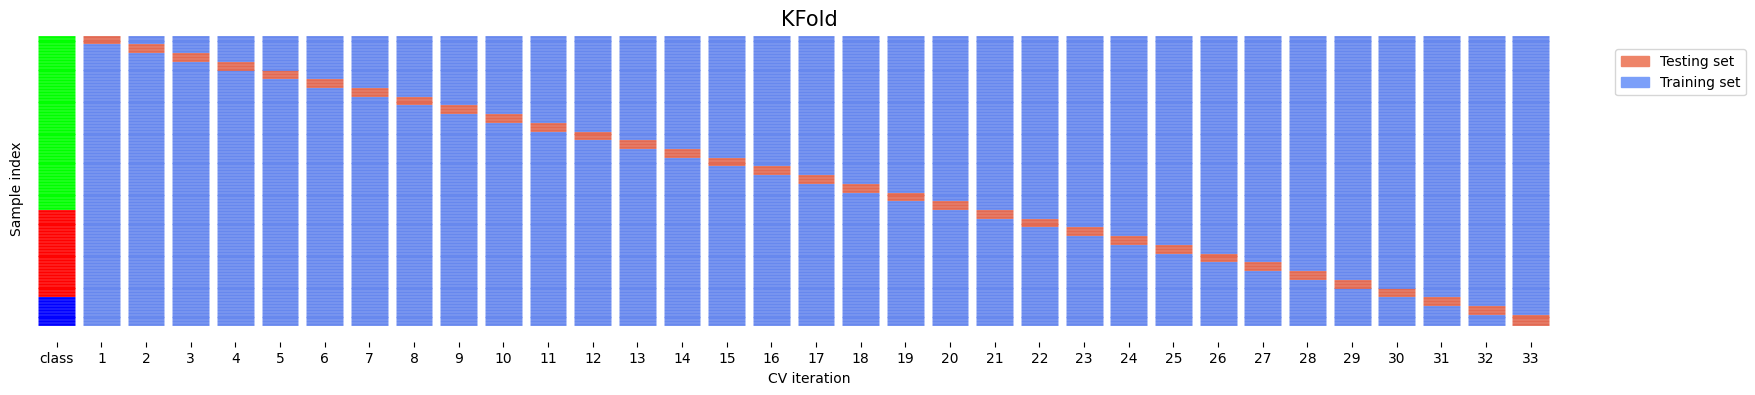

In [19]:
fig, ax = plt.subplots(figsize=(20, 4))
cv = KFold(33) # There are more than 33 classes, but this visualizes better.
plot_cv_indices(cv, X, y, groups, ax, s=700)
ax.set_ylim((-6, 100));

#### Validación cruzada Shuffle-Split
- Baraja los datos, muestrea puntos (`train_size`)  aleatoriamente como el conjunto de entrenamiento
- útil con conjuntos de datos muy grandes
- Nunca se utiliza si los datos están ordenados (por ejemplo, series temporales)

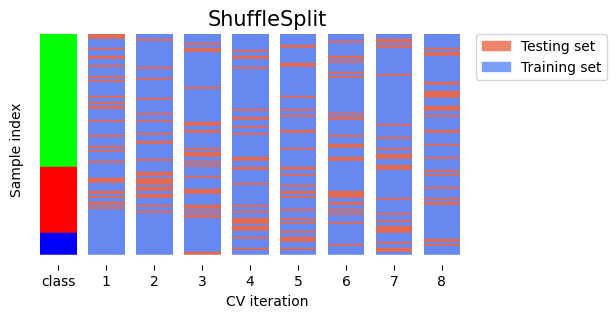

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
cv = ShuffleSplit(8, test_size=.2)
plot_cv_indices(cv, X, y, groups, ax, n_splits, s=700)
ax.set_ylim((-6, 100))
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
          ['Testing set', 'Training set'], loc=(.95, .8));

### El bootstrap
- Muestrea _n_ (tamaño del conjunto de datos) puntos de datos, con reemplazo, como conjunto de entrenamiento (el bootstrap)
    - Por término medio, las muestras bootstrap incluyen el 66% de todos los puntos de datos (algunos son duplicados)
- Utilice las muestras no muestreadas (fuera de bootstrap) como conjunto de prueba
- Repetir $k$ veces para obtener $k$ puntuaciones
- Similar a Shuffle-Split con `train_size=0.66`, `test_size=0.34` pero sin duplicados

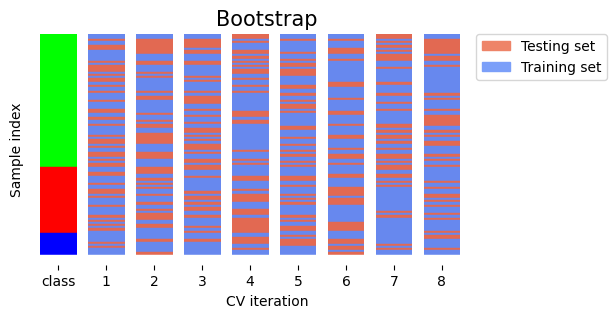

In [21]:
from sklearn.utils import resample

# Toy implementation of bootstrapping
class Bootstrap:
    def __init__(self, nr):
        self.nr = nr
    
    def get_n_splits(self, X, y, groups=None):
        return self.nr
    
    def split(self, X, y, groups=None):
        indices = range(len(X))
        splits = []
        for i in range(self.nr):
            train = resample(indices, replace=True, n_samples=len(X), random_state=i)
            test = list(set(indices) - set(train))
            splits.append((train, test))
        return splits
            
fig, ax = plt.subplots(figsize=(6, 3))
cv = Bootstrap(8)
plot_cv_indices(cv, X, y, groups, ax, n_splits, s=700)
ax.set_ylim((-6, 100))
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
          ['Testing set', 'Training set'], loc=(.95, .8));

### Validación cruzada repetida
- La validación cruzada sigue siendo sesgada en el sentido de que la división inicial puede hacerse de muchas maneras
- Validación cruzada repetida, o n-veces-k-veces:
    - Barajar los datos aleatoriamente, hacer una validación cruzada k-fold
    - Se repite n veces y se obtienen n veces k puntuaciones
- Insesgada, muy robusta, pero n veces más cara.

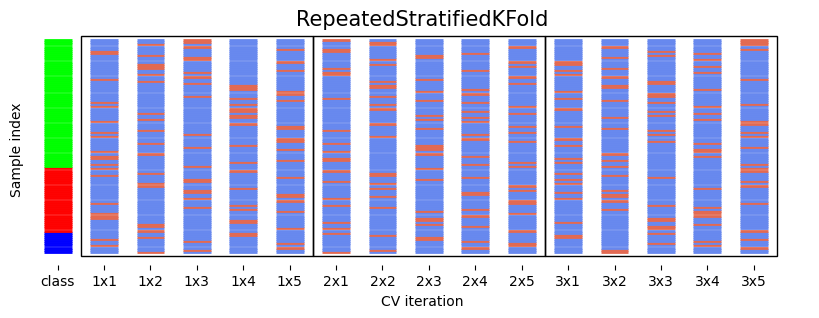

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(10, 3))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
plot_cv_indices(cv, X, y, groups, ax, lw=2, s=400, legend=False)
ax.set_ylim((-6, 102))
xticklabels = ["class"] + [f"{repeat}x{split}" for repeat in range(1, 4) for split in range(1, 6)]
ax.set_xticklabels(xticklabels)
for i in range(3):
    rect = Rectangle((-.5 + i * 5, -2.), 5, 103, edgecolor='k', facecolor='none')
    ax.add_artist(rect)

### Elección de un procedimiento de estimación del rendimiento
No hay reglas estrictas, sólo directrices:

- Utilizar siempre la estratificación para la clasificación (sklearn lo hace por defecto)
- Utilice holdout para conjuntos de datos muy grandes (por ejemplo, >1.000.000 ejemplos)
    - O cuando los aprendices no siempre convergen (por ejemplo, aprendizaje profundo)
- Elija _k_ en función del tamaño del conjunto de datos y los recursos
    - Utilice LOO para conjuntos de datos muy pequeños (por ejemplo, <100 ejemplos)
    - En caso contrario, utilice la validación cruzada
        - Más popular (y teóricamente sólido): CV de 10 veces
        - La bibliografía sugiere que 5x2 veces CV es mejor
- Utilice la agrupación o la exclusión de un solo sujeto para datos agrupados
- Utilizar "entrenar y luego probar" para series temporales

Para mas información consulte [diferentes estrategias CV en scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators)